## <b>Problem Definition</b>
**The context:**  <br>
**The objectives:** The goal of this notebook is to explore and process the data for use in deep learning neural networks.<br>
**The key questions:** Is the data balanced? Is there anything abnormal about the images? Do I need to downsample or collect more data?<br>
**The problem formulation:** Can we use deep learning as a diagnostic model for malaria?

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


###<b> Mounting the Drive

In [1]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This Notebook is run on google colab to make use of google colabs GPUs for efficient processing of images.

### <b>Loading libraries</b>

In [2]:
#Importing libraries required to load the data

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

### <b>Load the data</b>

In [3]:
#Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Colab Notebooks/cell_images.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

I will first do this for training data first and then we will use the same code for the test data.

In [4]:
#Storing the path of the extracted "train" folder 
train_dir = '/content/cell_images/train'

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [5]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            #Resizing each image to (64,64)
            image = image.resize((SIZE, SIZE))

            #Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [6]:
#Storing the path of the extracted "test" folder 
test_dir = '/content/cell_images/test'

#Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

#Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

#Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [7]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            #Resizing each image to (64,64)
            image = image.resize((SIZE, SIZE))
            
            #Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

###<b> Checking the shape of train and test images

In [8]:
# shape of images
print('length of training data set:', len(train_images))
print('length of testing data set:', len(test_images))
print('Shape of images:', train_images[0].shape)
print('First image:\n', train_images[0])

length of training data set: 24958
length of testing data set: 2600
Shape of images: (64, 64, 3)
First image:
 [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


###<b> Checking the shape of train and test labels

In [9]:
# shape of labels 
print('length of training labels set:', len(train_labels))
print('length of testing labels set:', len(test_labels))
print('Shape of labels:', train_labels.shape)

length of training labels set: 24958
length of testing labels set: 2600
Shape of labels: (24958,)


#####<b> Observations and insights: 
- The length of the train images matches the length of the train labels.
- The length of the test images matches the length of the test labels.
- There are 24958 images in the training data set and 2600 images in the test data set.
- Shape of a the first image in the data set is is (64,64,3)



### <b>Check the minimum and maximum range of pixel values for train and test images

In [10]:
# try to use min and max function from numpy
print(np.min(train_images))
print(np.max(train_images))

0
255


#####<b> Observations and insights: 
- The range for pixels in the image data set is between 255 and 0.
- We could probably delete the images whose pixel value is 0? 



###<b> Count the number of values in both uninfected and parasitized 

In [11]:
# try to use value_counts to count the values
tmp = pd.DataFrame(train_labels)
print(tmp[0].value_counts())

tmptest = pd.DataFrame(test_labels)
print(tmptest[0].value_counts())

1    12582
0    12376
Name: 0, dtype: int64
1    1300
0    1300
Name: 0, dtype: int64


#####<b> Observations and insights: 
- 0 is uninfected and 1 is parasatized.
- There are 12582 parasatized images and 12376 uninfected images in the training data set.
- The testing data set has 1300 of each parasatized and uninfected images.



###<b>Normalize the images

In [12]:
# try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function
train_images = (train_images).astype('float32') /255
test_images = (test_images).astype('float32') /255

###<b> Plot to check if the data is balanced

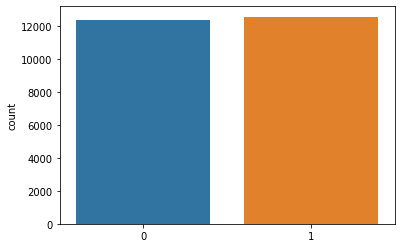

In [30]:
# you are free to use bar plot or pie-plot or count plot, etc. to plot the labels of train and test data and check if they are balanced
sns.countplot(train_labels)

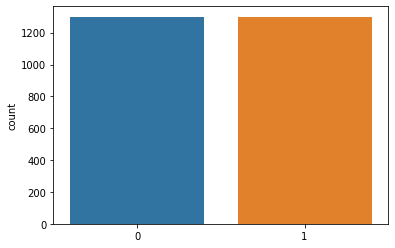

In [31]:
sns.countplot(test_labels)

#####<b> Observations and insights:
- The data is balanced. We can see that from just observing the numbers from value_counts.
- Plotting box plots also allows us to easily visualize that about 50% of both the test and training data sets are parasitized images and 50% of both sets are uninfected images.

### <b>Data Exploration</b>
Let's visualize the images from the train data

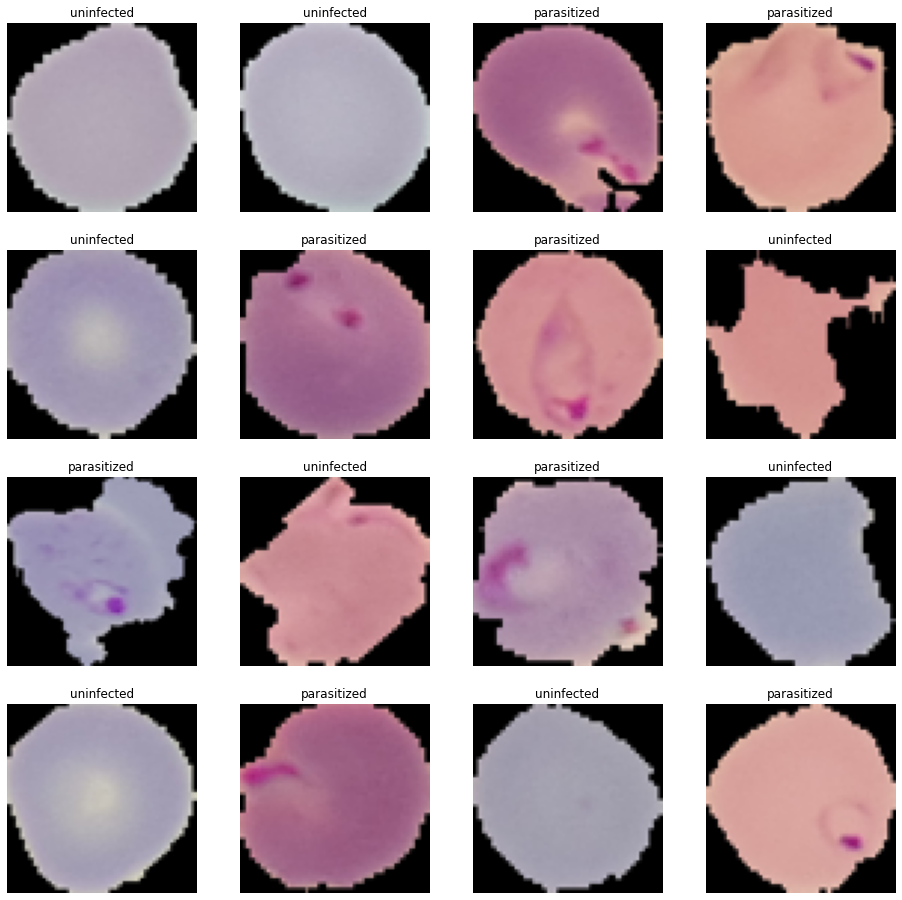

In [14]:
# Visualize both the parasitized and uninfected images
np.random.seed(42)
plt.figure(1 , figsize = (16 , 16))

for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, train_images.shape[0], 1))
    if train_labels[index] == 1: 
        plt.title('parasitized')
    else:
        plt.title('uninfected')
    plt.imshow(train_images[index])
    plt.axis('off')

#####<b> Observations and insights: 
- All of the parasitized cells have a little purple in them.
- The uninfected cells are fairly monocolored.
- the shade of the color seems to matter less than having a purple/pink discolor.
- Some of the blood cells are much more circular than others. I wonder if are results would be different if we only took into account the near perfect circular cells. The non perfect circles may have been damaged during the slide mounting process.

###<b> Similarly visualize the images with subplot(6,6) and figsize=(12,12)

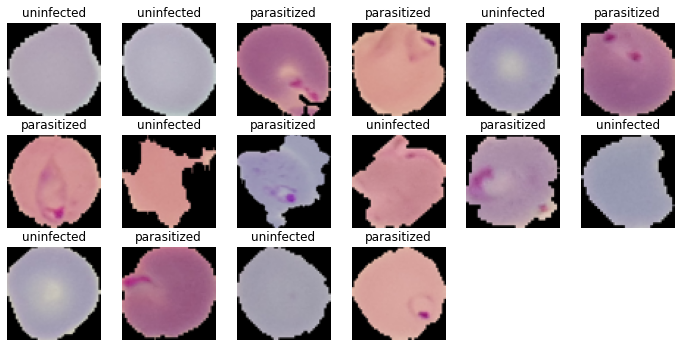

In [15]:
# Hint: Have a keen look into the number of iterations that the for loop should iterate
np.random.seed(42)
plt.figure(1 , figsize = (12 , 12))

for n in range(1, 17):
    plt.subplot(6, 6, n)
    index = int(np.random.randint(0, train_images.shape[0], 1))
    if train_labels[index] == 1: 
        plt.title('parasitized')
    else:
        plt.title('uninfected')
    plt.imshow(train_images[index])
    plt.axis('off')


#####<b>Observations and insights:
- This to me is a nicer way to visualize this data set. Before, the images were a bit too pixelated and this way we can visualize more picture more easily.

###<b> Plotting the mean images for parasitized and uninfected

In [16]:
# function to find the mean
def find_mean_img(full_mat, title):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)[0]
    # reshape it back to a matrix
    plt.imshow(mean_img)
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

<b> Mean image for parasitized

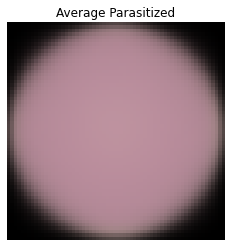

In [17]:
# If the label=1 then the image is parasitised and if the label=0 then the image is uninfected
parasitized_data=[]                                # Create a list to store the parasitized data
for img, label in zip(train_images, train_labels):
        if label==1:
              parasitized_data.append([img])          

parasitized_mean = find_mean_img(np.array(parasitized_data), 'Parasitized')   # find the mean

<b> Mean image for uninfected

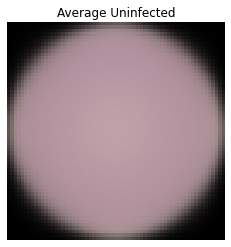

In [18]:
# Similarly write the code to find the mean image of uninfected
uninfected_data=[]                                # Create a list to store the parasitized data
for img, label in zip(train_images, train_labels):
        if label==0:
              uninfected_data.append([img])          

uninfected_mean = find_mean_img(np.array(uninfected_data), 'Uninfected')   # find the mean

#####<b> Observations and insights: 
- They look basically the same.
- The average parasitized has a bit more of a pink hue. This is expected as parasitized cells have those pink blotchy spots.
- Makes sense that there are no blotches.
- It is a good sign that the average is perfect circles.

### <b>Converting RGB to HSV of Images using OpenCV

####<b> Converting the train data

In [19]:
import cv2
gfx=[]   # to hold the HSV image array
for i in np.arange(0,100,1):
  a=cv2.cvtColor(train_images[i],cv2.COLOR_BGR2HSV)
  gfx.append(a)
gfx=np.array(gfx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


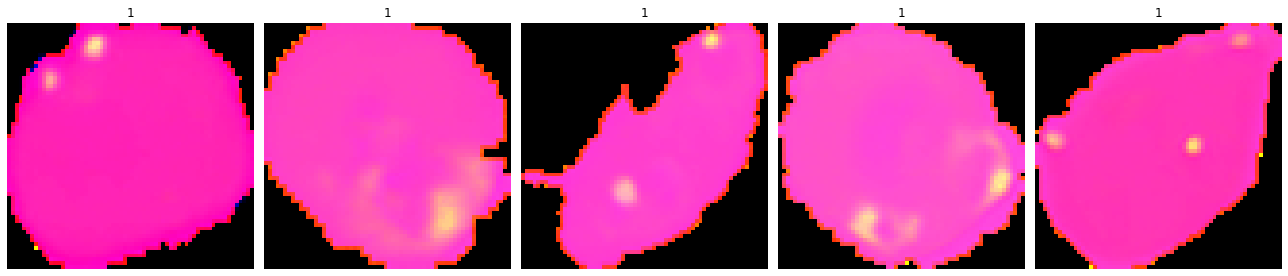

In [20]:
viewimage=np.random.randint(1,100,5)
fig,ax=plt.subplots(1,5,figsize=(18,18))
for t,i in zip(range(5),viewimage):
  Title=train_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gfx[i])
  ax[t].set_axis_off()
  fig.tight_layout()

####<b> Converting the test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


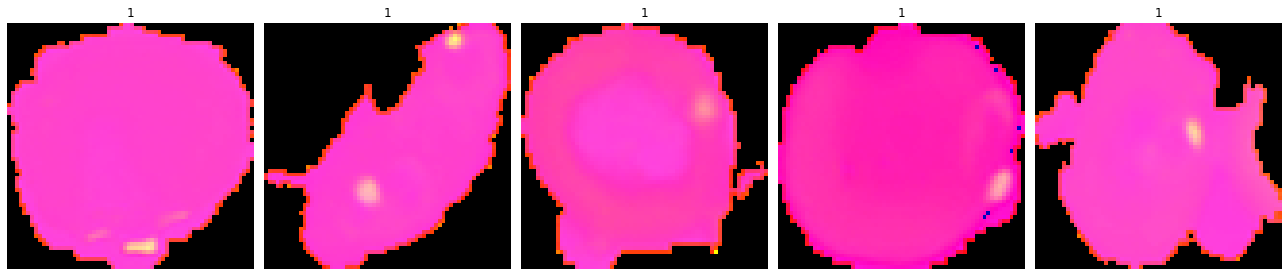

In [21]:
# Similarly you can visualize for the images in the test data
viewimage=np.random.randint(1,100,5)
fig,ax=plt.subplots(1,5,figsize=(18,18))
for t,i in zip(range(5),viewimage):
  Title=test_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gfx[i])
  ax[t].set_axis_off()
  fig.tight_layout()

#####<b>Observations and insights: 
- Different images is a good sign that the code is pulling from the 2 different sets.
- The edges of the cells hace a darker red color. This is probably just the cell membrane being imaged.
- Seems like parasitization comes through as yellow with this converted color scheme.

###<b> Processing Images using Gaussian Blurring

####<b> Gaussian Blurring on train data

In [22]:
gbx=[]  ## to hold the blurred images
for i in np.arange(0,100,1):
  b= cv2.GaussianBlur(train_images[i], (5, 5), 0)
  gbx.append(b)
gbx=np.array(gbx)

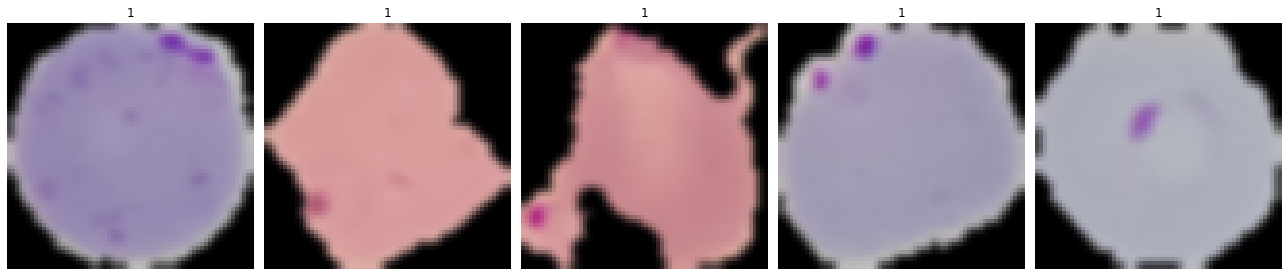

In [23]:
viewimage=np.random.randint(1,100,5)
fig,ax=plt.subplots(1,5,figsize=(18,18))
for t,i in zip(range(5),viewimage):
  Title=train_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gbx[i])
  ax[t].set_axis_off()
  fig.tight_layout()

####<b> Gaussian Blurring on test data

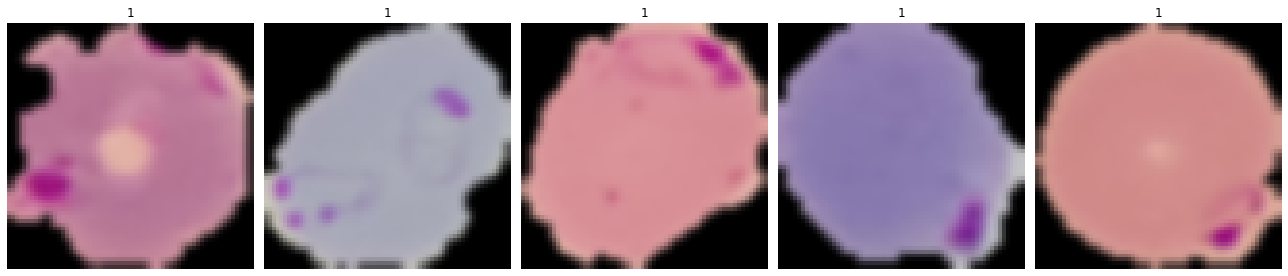

In [24]:
# Similarly you can apply Gaussian blurring for the images in the test data
viewimage=np.random.randint(1,100,5)
fig,ax=plt.subplots(1,5,figsize=(18,18))
for t,i in zip(range(5),viewimage):
  Title=test_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gbx[i])
  ax[t].set_axis_off()
  fig.tight_layout()

#####**Observations and insights:**

- Our images are blurred!
- There is no salt and pepper noise that would affect diagnostics so gaussian blur is a viable option.

- I decided not to use Gaussian blurring in the actual neural networks since I am using edge detection algorithms. 

## **Proposed approach**


- My first thought is to use a convolutional neural network to soolve this problem and get our desired output which is a diagnostic tool. We can also try just using an ANN and seeing what the metrics look like between the 2.
- Key measures will be metrics of precision, recall, and F-1 from our model. Read more detail in the project report. We don't want to misclassify anyone with a positive malaria case as uninfected as this could be detrimental to their wellbeing. We also don't want to classify an uninfected person as having malaria as this could slow down physicians from finding the actual reason for that person's illness. In this case we need both a high precision (high percentage of estimated TRUE malaria from our test data that are actually TRUE) and high recall (low number of misclassified TRUE malarias.